# Прогноз курса акций Tesla с помощью Facebook Prophet

Импортируем нужные библиотеки

In [3]:
import pandas as pd
import numpy as np
from datetime import date
import holidays # входит в fbpropet package
from fbprophet import Prophet

Готовим датасет для анализа. Можно скачать с сайта [Nasdaq](https://www.nasdaq.com/market-activity/stocks/tsla/historical)

In [4]:
df1=pd.read_csv('C:/Users/Vladimir/Coding/CSV_Datasets/tsla1year.csv')

In [5]:
df1.shape

(251, 6)

In [6]:
df1.head()

,Date,Close/Last,Volume,Open,High,Low
0,11/20/2020,$489.61,32911920,$497.99,$502.5,$489.06
1,11/19/2020,$499.27,62475350,$492,$508.6112,$487.57
2,11/18/2020,$486.64,78044020,$448.35,$496,$443.5001
3,11/17/2020,$441.61,61188280,$460.17,$462,$433.01
4,11/16/2020,$408.09,26838640,$408.93,$412.45,$404.0868


In [7]:
# предсказывать будем по цене закрытия. Удаляем ненужные столбцы.
df = df1.drop([' Volume', ' Open', ' High', ' Low'], axis=1)

In [8]:
# задаем новые имена столбцам для удобства
df.rename(columns={'Date': 'ds', ' Close/Last': 'y'}, inplace=True)

In [9]:
df['ds'] = pd.to_datetime(df.ds)# переведем дату к типу datetime, чтобы prophet не спотыкнулся

In [10]:
# уберем знак $ из котировок и приведем к дробному формату
df[df.columns[1]] = df[df.columns[1]].apply(lambda x: x.replace('$','')).astype(float)

In [11]:
# проверяем типы полей датафрейма. Всё ок!
df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [12]:
# отсортируем датафрейм в порядке возрастания даты
df=df.sort_values(by='ds', ascending=True)

In [13]:
# и пересоберем индекс
df = df.reset_index(drop=True)

In [14]:
# смотрим
df.head()

,ds,y
0,2019-11-25,67.268
1,2019-11-26,65.784
2,2019-11-27,66.258
3,2019-11-29,65.988
4,2019-12-02,66.974


Настраиваем Prophet

In [21]:
# создадим датафрейм с праздниками США, чтобы посмотреть влияют ли они на котировки
holidays_dict = holidays.US(years=(2019, 2020, 2021))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays

,ds,holiday
0,2019-01-01,New Year's Day
1,2019-01-21,Martin Luther King Jr. Day
2,2019-02-18,Washington's Birthday
3,2019-05-27,Memorial Day
4,2019-07-04,Independence Day
5,2019-09-02,Labor Day
6,2019-10-14,Columbus Day
7,2019-11-11,Veterans Day
8,2019-11-28,Thanksgiving
9,2019-12-25,Christmas Day


In [53]:
# Период, на котором будем предсказывать
predictions = 7

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество модели
train_df = df[:-predictions]

In [54]:
# Настраиваем prophet – говорим ему учитывать праздники и сезонности
# daily_seasonality - для расчета колебаний внутри дня (отключаем, у нас датасет по дням)
# weekly_seasonality - для расчета колебаний по недели (активируем)
# yearly_seasonality - для расчета колебаний по году (отключаем. нас интересует малый период)
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
# запускаем обучение на выборке
m.fit(train_df)

In [55]:
# Делаем предсказание на наш период
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

Визуализируем результаты

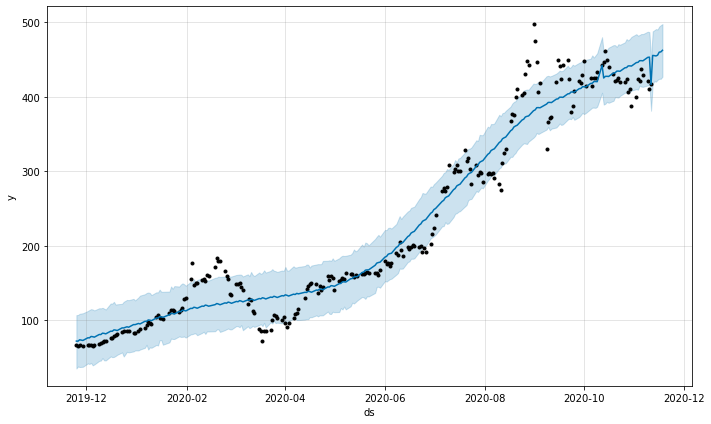

In [56]:
m.plot(forecast);
# Черные точки - это фактические значения. Синия линия - это предсказанные значения

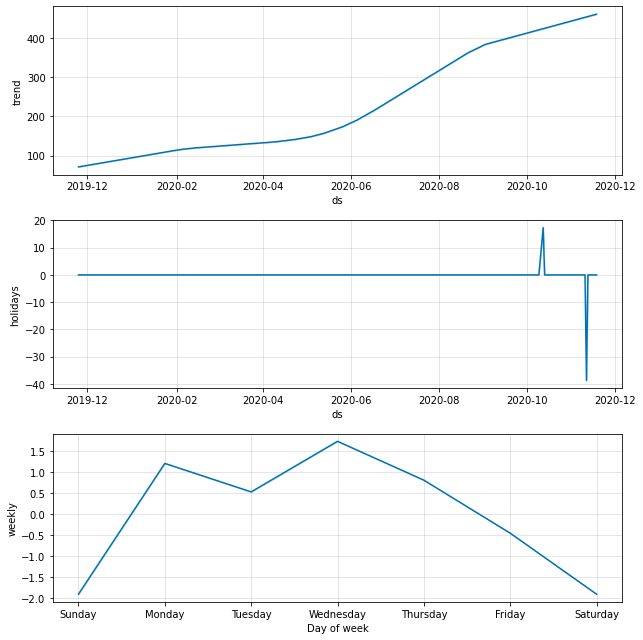

In [57]:
# Смотрим на сезонности
m.plot_components(forecast);
# первый график - отчетливо видна линия восходящего тренда
# второй график - влияние двух прездников. Октябрь - День Колумба и Ноябрь - День Ветеранов
# третий график - понятная ситуация, что на выходные биржа закрывается поэтому график такой горбатый.

In [37]:
# Теперь с помощью plotly нарисуем более продвинутый, интерактивный график
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

In [38]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  8.814316922813399 %
MAE (средняя абсолютная ошибка) –  37.11964247775222


In [51]:
# Проверим на еще одну ошибку - какие дни были предсказаны лишне
# Значения NaN - это дни, которые были предсказаны, хотя по календарю это выходные и биржа не работает
nan_df = cmp_df[cmp_df.isna().any(axis=1)]
display(nan_df.tail(5))#display - когда нужно вывести промежуточный результат без принта

,yhat,yhat_lower,yhat_upper,y,e,p
ds,,,,,,
2020-11-14,454.957172,420.800708,490.590097,NaN,NaN,NaN
2020-11-15,455.957837,420.716563,492.823063,NaN,NaN,NaN


In [43]:
# теперь сделаем прогноз на 2 недели вперед
prediction_days = 14
final_train_df = df
f = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_days)
final_forecast = f.predict(final_future)

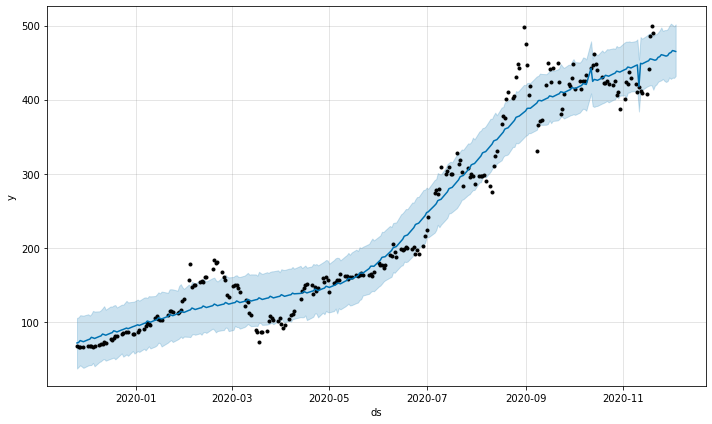

In [49]:
# Смотрим, что предсказалось на полный период
f.plot(final_forecast);

In [46]:
# Рисуем график на двухнедельном периоде
iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat'], name='prediction'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['trend'], name='trend')
])

In [59]:
# Выгружаем прогноз в Excel. Спрогнозированное значение лежит в столбце yhat
final_forecast.to_excel("./forecast.xlsx", sheet_name='Forecast', index=False, encoding="cp1251")